时间序列（time series）数据是⼀种重要的结构化数据形式。  

在多个时间点观察或测量到的任何事物都可以形成⼀段时间序列。很多时间序列是固定频率的，也就是说，数据点是根据某种规律定期出现的（⽐如每15秒、每5分钟、每⽉出现⼀次）。时间序列也可以是不定期的，没有固定的时间单位或单位之间的偏移量。时间序列数据的意义取决于具体的应⽤场景，主要有以下⼏种：  
- 时间戳（timestamp），特定的时刻。
- 固定时期（period），如2007年1⽉或2010年全年。
- 时间间隔（interval），由起始和结束时间戳表示。时期（period）可以被看做间隔（interval）的特例。
- 实验或过程时间，每个时间点都是相对于特定起始时间的⼀个度量。例如，从放⼊烤箱时起，每秒钟饼⼲的直径。  

本章主要讲解前3种时间序列。许多技术都可⽤于处理实验型时间序列，其索引可能是⼀个整数或浮点数（表示从实验开始算起已经过去的时间）。最简单也最常⻅的时间序列都是⽤时间戳进⾏索引的。  
提示：pandas也⽀持基于timedeltas的指数，它可以有效代表实验或经过的时间。这本书不涉及timedelta指数，但你可以学习pandas的⽂档（http://pandas.pydata.org/ ）。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## ⽇期和时间数据类型及⼯具
Python标准库包含⽤于⽇期（date）和时间（time）数据的数据类型，⽽且还有⽇历⽅⾯的功能。我们主要会⽤到datetime、time以及calendar模块。datetime.datetime（也可以简写为datetime）是⽤得最多的数据类型：

In [2]:
from datetime import datetime
now = datetime.now()
now

datetime.datetime(2021, 3, 20, 8, 3, 45, 789335)

In [3]:
now.year, now.month, now.day

(2021, 3, 20)

datetime以毫秒形式存储⽇期和时间。timedelta表示两个datetime对象之间的时间差：

In [4]:
delta = datetime(2011, 1, 7) - datetime(2008, 6, 24, 8, 15)
delta

datetime.timedelta(days=926, seconds=56700)

In [5]:
delta.days

926

In [6]:
delta.seconds

56700

可以给datetime对象加上（或减去）⼀个或多个timedelta，这样会产⽣⼀个新对象：

In [7]:
from datetime import timedelta
start = datetime(2011, 1, 7)
start + timedelta(12)

datetime.datetime(2011, 1, 19, 0, 0)

In [8]:
start - 2 * timedelta(12)

datetime.datetime(2010, 12, 14, 0, 0)

表11-1 datetime模块中的数据类型
![](./表11-1datetime模块中的数据类型.jpg)

### 字符串和datetime的相互转换
利⽤str或strftime⽅法（传⼊⼀个格式化字符串），datetime对象和pandas的Timestamp对象（稍后就会介绍）可以被格式化为字符串：

In [9]:
stamp = datetime(2011, 1, 3)
str(stamp)

'2011-01-03 00:00:00'

In [10]:
stamp.strftime('%Y-%m-%d')

'2011-01-03'

表11-2 datetime格式定义（兼容ISO C89）
![](./表11-2datetime格式定义.jpg)

datetime.strptime可以⽤这些格式化编码将字符串转换为⽇期：

In [11]:
value = '2011-01-03'
datetime.strptime(value, '%Y-%m-%d')

datetime.datetime(2011, 1, 3, 0, 0)

In [12]:
datestrs = ['7/6/2011', '8/6/2011']
[datetime.strptime(x, '%m/%d/%Y') for x in datestrs]

[datetime.datetime(2011, 7, 6, 0, 0), datetime.datetime(2011, 8, 6, 0, 0)]

datetime.strptime是通过已知格式进⾏⽇期解析的最佳⽅式。但是每次都要编写格式定义是很麻烦的事情，尤其是对于⼀些常⻅的⽇期格式。这种情况下，你可以⽤dateutil这个第三⽅包中的parser.parse⽅法（pandas中已经⾃动安装好了）：

In [13]:
from dateutil.parser import parse
parse('2011-01-03')

datetime.datetime(2011, 1, 3, 0, 0)

dateutil可以解析⼏乎所有⼈类能够理解的⽇期表示形式：

In [14]:
parse('Jan 31, 1997 10:45 PM')

datetime.datetime(1997, 1, 31, 22, 45)

在国际通⽤的格式中，⽇出现在⽉的前⾯很普遍，传⼊`dayfirst=True`即可解决这个问题：

In [15]:
parse('6/12/2011', dayfirst=True)

datetime.datetime(2011, 12, 6, 0, 0)

pandas通常是⽤于处理成组⽇期的，不管这些⽇期是DataFrame的轴索引还是列。to_datetime⽅法可以解析多种不同的⽇期表示形式。对标准⽇期格式（如ISO8601）的解析⾮常快：

In [16]:
datestrs = ['2011-07-06 12:00:00', '2011-08-06 00:00:00']
pd.to_datetime(datestrs)

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00'], dtype='datetime64[ns]', freq=None)

它还可以处理缺失值（None、空字符串等）：

In [17]:
idx = pd.to_datetime(datestrs + [None])
idx

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00', 'NaT'], dtype='datetime64[ns]', freq=None)

In [18]:
idx[2]

NaT

In [19]:
pd.isnull(idx)

array([False, False,  True])

NaT（Not a Time）是pandas中时间戳数据的null值。  

注意：dateutil.parser是⼀个实⽤但不完美的⼯具。⽐如说，它会把⼀些原本不是⽇期的字符串认作是⽇期（⽐如"42"会被解析为2042年的今天）。  

datetime对象还有⼀些特定于当前环境（位于不同国家或使⽤不同语⾔的系统）的格式化选项。例如，德语或法语系统所⽤的⽉份简写就与英语系统所⽤的不同。表11-3进⾏了总结。   

表11-3 特定于当前环境的⽇期格式
![](./表11-3特定于当前环境的⽇期格式.jpg)

## 时间序列基础
pandas最基本的时间序列类型就是以时间戳（通常以Python字符串或datatime对象表示）为索引的Series：

In [20]:
from datetime import datetime
dates = [datetime(2011, 1, 2), datetime(2011, 1, 5),
         datetime(2011, 1, 7), datetime(2011, 1, 8),
         datetime(2011, 1, 10), datetime(2011, 1, 12)]
ts = pd.Series(np.random.randn(6), index=dates)
ts

2011-01-02   -0.791712
2011-01-05   -0.741464
2011-01-07   -0.087062
2011-01-08    1.654423
2011-01-10   -1.269186
2011-01-12   -0.073195
dtype: float64

这些datetime对象实际上是被放在⼀个DatetimeIndex中的：

In [21]:
ts.index

DatetimeIndex(['2011-01-02', '2011-01-05', '2011-01-07', '2011-01-08',
               '2011-01-10', '2011-01-12'],
              dtype='datetime64[ns]', freq=None)

跟其他Series⼀样，不同索引的时间序列之间的算术运算会⾃动按⽇期对⻬：

In [22]:
ts + ts[::2]

2011-01-02   -1.583425
2011-01-05         NaN
2011-01-07   -0.174124
2011-01-08         NaN
2011-01-10   -2.538373
2011-01-12         NaN
dtype: float64

pandas⽤NumPy的datetime64数据类型以纳秒形式存储时间戳：

In [23]:
ts.index.dtype

dtype('<M8[ns]')

DatetimeIndex中的各个标量值是pandas的Timestamp对象：

In [24]:
stamp = ts.index[0]
stamp

Timestamp('2011-01-02 00:00:00')

只要有需要，TimeStamp可以随时⾃动转换为datetime对象。此外，它还可以存储频率信息（如果有的话），且知道如何执⾏时区转换以及其他操作。稍后将对此进⾏详细讲解。

### 索引、选取、⼦集构造
当你根据标签索引选取数据时，时间序列和其它的`pandas.Series`很像：

In [25]:
stamp = ts.index[2]
ts[stamp]

-0.087062179515317

还有⼀种更为⽅便的⽤法：传⼊⼀个可以被解释为⽇期的字符串：

In [26]:
ts['1/10/2011']

-1.269186329134087

In [27]:
ts['20110110']

-1.269186329134087

对于较⻓的时间序列，只需传⼊“年”或“年⽉”即可轻松选取数据的切⽚：

In [28]:
longer_ts = pd.Series(np.random.randn(1000),
                      index=pd.date_range('1/1/2000', periods=1000))  # periods：要生成的周期数。
longer_ts

2000-01-01    1.419329
2000-01-02    0.187395
2000-01-03   -1.704569
2000-01-04    0.892298
2000-01-05    0.413080
                ...   
2002-09-22    0.154439
2002-09-23   -1.380943
2002-09-24    1.381952
2002-09-25    0.681981
2002-09-26    0.281220
Freq: D, Length: 1000, dtype: float64

In [29]:
longer_ts['2001']

2001-01-01   -0.117669
2001-01-02    0.540614
2001-01-03   -2.371492
2001-01-04   -0.371993
2001-01-05   -1.990308
                ...   
2001-12-27   -0.857726
2001-12-28   -0.037468
2001-12-29   -1.152043
2001-12-30   -1.040532
2001-12-31    0.760665
Freq: D, Length: 365, dtype: float64

这⾥，字符串“2001”被解释成年，并根据它选取时间区间。指定⽉也同样奏效：

In [30]:
longer_ts['2001-05']

2001-05-01    1.817370
2001-05-02   -0.550464
2001-05-03   -0.610834
2001-05-04    1.844247
2001-05-05   -0.800570
2001-05-06   -0.349408
2001-05-07   -0.150376
2001-05-08    1.048534
2001-05-09   -1.226323
2001-05-10   -0.192092
2001-05-11   -0.124137
2001-05-12    0.235290
2001-05-13    1.421823
2001-05-14    0.737931
2001-05-15    1.324940
2001-05-16   -0.825566
2001-05-17    1.650230
2001-05-18    0.453627
2001-05-19    1.211863
2001-05-20    1.628056
2001-05-21    0.771065
2001-05-22   -1.243086
2001-05-23    1.842547
2001-05-24    1.368856
2001-05-25    0.028141
2001-05-26   -0.871096
2001-05-27   -1.031580
2001-05-28   -1.972618
2001-05-29   -1.520103
2001-05-30   -0.038544
2001-05-31   -0.187812
Freq: D, dtype: float64

datetime对象也可以进⾏切⽚：

In [31]:
ts[datetime(2011, 1, 7):]

2011-01-07   -0.087062
2011-01-08    1.654423
2011-01-10   -1.269186
2011-01-12   -0.073195
dtype: float64

由于⼤部分时间序列数据都是按照时间先后排序的，因此你也可以⽤不存在于该时间序列中的时间戳对其进⾏切⽚（即范围查询）：

In [32]:
ts

2011-01-02   -0.791712
2011-01-05   -0.741464
2011-01-07   -0.087062
2011-01-08    1.654423
2011-01-10   -1.269186
2011-01-12   -0.073195
dtype: float64

In [33]:
ts['1/6/2011':'1/11/2011']

2011-01-07   -0.087062
2011-01-08    1.654423
2011-01-10   -1.269186
dtype: float64

跟之前⼀样，你可以传⼊字符串⽇期、datetime或Timestamp。  

注意，这样切⽚所产⽣的是源时间序列的视图，跟NumPy数组的切⽚运算是⼀样的。  

这意味着，没有数据被复制，对切⽚进⾏修改会反映到原始数据上。  

此外，还有⼀个等价的实例⽅法也可以截取两个⽇期之间TimeSeries：

In [34]:
ts.truncate(after='1/9/2011')

2011-01-02   -0.791712
2011-01-05   -0.741464
2011-01-07   -0.087062
2011-01-08    1.654423
dtype: float64

⾯这些操作对DataFrame也有效。例如，对DataFrame的⾏进⾏索引：

In [35]:
# freq:频率,参数详情（https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases）
dates = pd.date_range('1/1/2000', periods=100, freq='W-WED')  
long_df = pd.DataFrame(np.random.randn(100, 4),
                       index=dates,
                       columns=['Colorado', 'Texas',
                                'New York', 'Ohio'])
long_df.loc['5-2001']

,Colorado,Texas,New York,Ohio
2001-05-02,1.122143,-0.400895,-0.502434,-1.267450
2001-05-09,-0.532314,0.517659,0.766262,1.672697
2001-05-16,1.301102,0.380929,-0.049977,1.112240
2001-05-23,1.238031,-0.903798,-0.430761,-0.337984
2001-05-30,-0.200205,1.684385,1.169853,0.444099


### 带有重复索引的时间序列
在某些应⽤场景中，可能会存在多个观测数据落在同⼀个时间点上的情况。下⾯就是⼀个例⼦：

In [36]:
dates = pd.DatetimeIndex(['1/1/2000', '1/2/2000', '1/2/2000',
                          '1/2/2000', '1/3/2000'])
dup_ts = pd.Series(np.arange(5), index=dates)
dup_ts

2000-01-01    0
2000-01-02    1
2000-01-02    2
2000-01-02    3
2000-01-03    4
dtype: int32

通过检查索引的is_unique属性，我们就可以知道它是不是唯⼀的：

In [37]:
dup_ts.index.is_unique

False

对这个时间序列进⾏索引，要么产⽣标量值，要么产⽣切⽚，具体要看所选的时间点是否重复：

In [38]:
dup_ts['1/3/2000']  # 未重复

4

In [39]:
dup_ts['1/2/2000']  # 重复

2000-01-02    1
2000-01-02    2
2000-01-02    3
dtype: int32

假设你想要对具有⾮唯⼀时间戳的数据进⾏聚合。⼀个办法是使⽤groupby，并传⼊`level=0`：

In [40]:
grouped = dup_ts.groupby(level=0)
grouped.mean()

2000-01-01    0
2000-01-02    2
2000-01-03    4
dtype: int32

In [41]:
grouped.count()

2000-01-01    1
2000-01-02    3
2000-01-03    1
dtype: int64

## ⽇期的范围、频率以及移动
pandas中的原⽣时间序列⼀般被认为是不规则的，也就是说，它们没有固定的频率。对于⼤部分应⽤程序⽽⾔，这是⽆所谓的。但是，它常常需要以某种相对固定的频率进⾏分析，⽐如每⽇、每⽉、每15分钟等（这样⾃然会在时间序列中引⼊缺失值）。幸运的是，pandas有⼀整套标准时间序列频率以及⽤于重采样、频率推断、⽣成固定频率⽇期范围的⼯具。例如，我们可以将之前那个时间序列转换为⼀个具有固定频率（每⽇）的时间序列，只需调⽤resample即可：

In [42]:
ts

2011-01-02   -0.791712
2011-01-05   -0.741464
2011-01-07   -0.087062
2011-01-08    1.654423
2011-01-10   -1.269186
2011-01-12   -0.073195
dtype: float64

In [43]:
# 字符串“D”是每天的意思,参数详情（https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases）
resampler = ts.resample('D')

频率的转换（或重采样）是⼀个⽐较⼤的主题，稍后将专⻔⽤⼀节来进⾏讨论。这⾥，我将告诉你如何使⽤基本的频率和它的倍数。

### ⽣成⽇期范围
`pandas.date_range`可⽤于根据指定的频率⽣成指定⻓度的DatetimeIndex：

In [44]:
index = pd.date_range('2012-04-01', '2012-06-01')
index

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20',
               '2012-04-21', '2012-04-22', '2012-04-23', '2012-04-24',
               '2012-04-25', '2012-04-26', '2012-04-27', '2012-04-28',
               '2012-04-29', '2012-04-30', '2012-05-01', '2012-05-02',
               '2012-05-03', '2012-05-04', '2012-05-05', '2012-05-06',
               '2012-05-07', '2012-05-08', '2012-05-09', '2012-05-10',
               '2012-05-11', '2012-05-12', '2012-05-13', '2012-05-14',
               '2012-05-15', '2012-05-16', '2012-05-17', '2012-05-18',
               '2012-05-19', '2012-05-20', '2012-05-21', '2012-05-22',
               '2012-05-23', '2012-05-24', '2012-05-25', '2012-05-26',
      

默认情况下，date_range会产⽣按天计算的时间点。如果只传⼊起始或结束⽇期，那就还得传⼊⼀个表示⼀段时间的数字：

In [45]:
pd.date_range(start='2012-04-01', periods=20)

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20'],
              dtype='datetime64[ns]', freq='D')

In [46]:
pd.date_range(end='2012-06-01', periods=20)

DatetimeIndex(['2012-05-13', '2012-05-14', '2012-05-15', '2012-05-16',
               '2012-05-17', '2012-05-18', '2012-05-19', '2012-05-20',
               '2012-05-21', '2012-05-22', '2012-05-23', '2012-05-24',
               '2012-05-25', '2012-05-26', '2012-05-27', '2012-05-28',
               '2012-05-29', '2012-05-30', '2012-05-31', '2012-06-01'],
              dtype='datetime64[ns]', freq='D')

起始和结束⽇期定义了⽇期索引的严格边界。例如，如果你想要⽣成⼀个由每⽉最后⼀个⼯作⽇组成的⽇期索引，可以传⼊"BM"频率（表示business end of month，表11-4是频率列表），这样就只会包含时间间隔内（或刚好在边界上的）符合频率要求的⽇期：  
表11-4 基本的时间序列频率（不完整）
![](./表11-4基本的时间序列频率.jpg)
时间序列频率,同上面：freq:频率,参数详情(https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases) 一致

In [47]:
pd.date_range('2000-01-01', '2000-12-01', freq='BM')

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-28',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-29', '2000-10-31', '2000-11-30'],
              dtype='datetime64[ns]', freq='BM')

date_range默认会保留起始和结束时间戳的时间信息（如果有的话）：

In [48]:
pd.date_range('2012-05-02 12:56:31', periods=5)

DatetimeIndex(['2012-05-02 12:56:31', '2012-05-03 12:56:31',
               '2012-05-04 12:56:31', '2012-05-05 12:56:31',
               '2012-05-06 12:56:31'],
              dtype='datetime64[ns]', freq='D')

有时，虽然起始和结束⽇期带有时间信息，但你希望产⽣⼀组被规范化（normalize）到午夜的时间戳。normalize选项即可实现该功能：

In [49]:
pd.date_range('2012-05-02 12:56:31', periods=5, normalize=True)

DatetimeIndex(['2012-05-02', '2012-05-03', '2012-05-04', '2012-05-05',
               '2012-05-06'],
              dtype='datetime64[ns]', freq='D')

### 频率和⽇期偏移量
pandas中的频率是由⼀个基础频率（base frequency）和⼀个乘数组成的。基础频率通常以⼀个字符串别名表示，⽐如"M"表示每⽉，"H"表示每⼩时。对于每个基础频率，都有⼀个被称为⽇期偏移量（date offset）的对象与之对应。例如，按⼩时计算的频率可以⽤Hour类表示：

In [50]:
from pandas.tseries.offsets import Hour, Minute
hour = Hour()
hour

<Hour>

传⼊⼀个整数即可定义偏移量的倍数：

In [51]:
four_hours = Hour(4)
four_hours

<4 * Hours>

⼀般来说，⽆需明确创建这样的对象，只需使⽤诸如"H"或"4H"这样的字符串别名即可。在基础频率前⾯放上⼀个整数即可创建倍数：

In [52]:
pd.date_range('2000-01-01', '2000-01-03 23:59', freq='4h')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 04:00:00',
               '2000-01-01 08:00:00', '2000-01-01 12:00:00',
               '2000-01-01 16:00:00', '2000-01-01 20:00:00',
               '2000-01-02 00:00:00', '2000-01-02 04:00:00',
               '2000-01-02 08:00:00', '2000-01-02 12:00:00',
               '2000-01-02 16:00:00', '2000-01-02 20:00:00',
               '2000-01-03 00:00:00', '2000-01-03 04:00:00',
               '2000-01-03 08:00:00', '2000-01-03 12:00:00',
               '2000-01-03 16:00:00', '2000-01-03 20:00:00'],
              dtype='datetime64[ns]', freq='4H')

⼤部分偏移量对象都可通过加法进⾏连接：

In [53]:
Hour(2) + Minute(30)

<150 * Minutes>

同理，你也可以传⼊频率字符串（如"2h30min"），这种字符串可以被⾼效地解析为等效的表达式：

In [54]:
pd.date_range('2000-01-01', periods=10, freq='1h30min')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:30:00',
               '2000-01-01 03:00:00', '2000-01-01 04:30:00',
               '2000-01-01 06:00:00', '2000-01-01 07:30:00',
               '2000-01-01 09:00:00', '2000-01-01 10:30:00',
               '2000-01-01 12:00:00', '2000-01-01 13:30:00'],
              dtype='datetime64[ns]', freq='90T')

有些频率所描述的时间点并不是均匀分隔的。例如，"M"（⽇历⽉末）和"BM"（每⽉最后⼀个⼯作⽇）就取决于每⽉的天数，对于后者，还要考虑⽉末是不是周末。由于没有更好的术语，我将这些称为锚点偏移量（anchored offset）。  

表11-4列出了pandas中的频率代码和⽇期偏移量类。  
笔记：⽤户可以根据实际需求⾃定义⼀些频率类以便提供pandas所没有的⽇期逻辑，但具体的细节超出了本书的范围。  

### WOM⽇期
WOM（Week Of Month）是⼀种⾮常实⽤的频率类，它以WOM开头。它使你能获得诸如“每⽉第3个星期五”之类的⽇期：

In [55]:
rng = pd.date_range('2012-01-01', '2012-09-01', freq='WOM-3FRI')
list(rng)

[Timestamp('2012-01-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-02-17 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-03-16 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-04-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-05-18 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-06-15 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-07-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-08-17 00:00:00', freq='WOM-3FRI')]

### 移动（超前和滞后）数据
移动（shifting）指的是沿着时间轴将数据前移或后移。Series和DataFrame都有⼀个shift⽅法⽤于执⾏单纯的前移或后移操作，保持索引不变：

In [56]:
ts = pd.Series(np.random.randn(4),
               index=pd.date_range('1/1/2000', periods=4, freq='M'))
ts

2000-01-31    0.270074
2000-02-29    0.054924
2000-03-31   -0.979433
2000-04-30   -0.201763
Freq: M, dtype: float64

In [57]:
ts.shift(2)

2000-01-31         NaN
2000-02-29         NaN
2000-03-31    0.270074
2000-04-30    0.054924
Freq: M, dtype: float64

In [58]:
ts.shift(-2)

2000-01-31   -0.979433
2000-02-29   -0.201763
2000-03-31         NaN
2000-04-30         NaN
Freq: M, dtype: float64

当我们这样进⾏移动时，就会在时间序列的前⾯或后⾯产⽣缺失数据。  

shift通常⽤于计算⼀个时间序列或多个时间序列（如DataFrame的列）中的百分⽐变化。可以这样表达：

In [59]:
ts / ts.shift(1) - 1

2000-01-31          NaN
2000-02-29    -0.796633
2000-03-31   -18.832390
2000-04-30    -0.794000
Freq: M, dtype: float64

由于单纯的移位操作不会修改索引，所以部分数据会被丢弃。因此，如果频率已知，则可以将其传给shift以便实现对时间戳进⾏位移⽽不是对数据进⾏简单位移：

In [60]:
ts.shift(2, freq='M')  # 将月份后移两月

2000-03-31    0.270074
2000-04-30    0.054924
2000-05-31   -0.979433
2000-06-30   -0.201763
Freq: M, dtype: float64

这⾥还可以使⽤其他频率，于是你就能⾮常灵活地对数据进⾏超前和滞后处理了：

In [61]:
ts.shift(3, freq='D')

2000-02-03    0.270074
2000-03-03    0.054924
2000-04-03   -0.979433
2000-05-03   -0.201763
dtype: float64

In [62]:
ts.shift(1, freq='90T')

2000-01-31 01:30:00    0.270074
2000-02-29 01:30:00    0.054924
2000-03-31 01:30:00   -0.979433
2000-04-30 01:30:00   -0.201763
dtype: float64

### 通过偏移量对⽇期进⾏位移
pandas的⽇期偏移量还可以⽤在datetime或Timestamp对象上：

In [63]:
from pandas.tseries.offsets import Day, MonthEnd
now = datetime(2011, 11, 17)
now + 3 * Day()

Timestamp('2011-11-20 00:00:00')

如果加的是锚点偏移量（⽐如MonthEnd），第⼀次增量会将原⽇期向前滚动到符合频率规则的下⼀个⽇期：

In [64]:
now + MonthEnd()

Timestamp('2011-11-30 00:00:00')

In [65]:
now + MonthEnd(2)

Timestamp('2011-12-31 00:00:00')

通过锚点偏移量的rollforward和rollback⽅法，可明确地将⽇期向前或向后“滚动”：

In [66]:
offset = MonthEnd()
offset.rollforward(now)

Timestamp('2011-11-30 00:00:00')

In [67]:
offset.rollback(now)

Timestamp('2011-10-31 00:00:00')

⽇期偏移量还有⼀个巧妙的⽤法，即结合groupby使⽤这两个“滚动”⽅法：

In [68]:
ts = pd.Series(np.random.randn(20),
               index=pd.date_range('1/15/2000', periods=20, freq='4d'))
ts

2000-01-15   -1.193075
2000-01-19    0.542955
2000-01-23   -0.403124
2000-01-27    1.050582
2000-01-31    0.440612
2000-02-04    0.908010
2000-02-08    0.590346
2000-02-12    1.089976
2000-02-16   -0.792137
2000-02-20    0.943432
2000-02-24    0.346820
2000-02-28   -0.079254
2000-03-03   -0.817156
2000-03-07   -0.455526
2000-03-11    0.810642
2000-03-15   -0.895683
2000-03-19    0.303746
2000-03-23   -0.566342
2000-03-27   -0.001521
2000-03-31    0.433674
Freq: 4D, dtype: float64

In [69]:
ts.groupby(offset.rollforward).mean()

2000-01-31    0.087590
2000-02-29    0.429599
2000-03-31   -0.148521
dtype: float64

当然，更简单、更快速地实现该功能的办法是使⽤resample（后面将进行详细介绍）：

In [70]:
ts.resample('M').mean()

2000-01-31    0.087590
2000-02-29    0.429599
2000-03-31   -0.148521
Freq: M, dtype: float64

## 时区处理
时间序列处理⼯作中最让⼈不爽的就是对时区的处理。许多⼈都选择以协调世界时（UTC，它是格林尼治标准时间（Greenwich Mean Time）的接替者，⽬前已经是国际标准了）来处理时间序列。时区是以UTC偏移量的形式表示的。例如，夏令时期间，纽约⽐UTC慢4⼩时，⽽在全年其他时间则⽐UTC慢5⼩时。  

在Python中，时区信息来⾃第三⽅库pytz，它使Python可以使⽤Olson数据库（汇编了世界时区信息）。这对历史数据⾮常重要，这是因为由于各地政府的各种突发奇想，夏令时转变⽇期（甚⾄UTC偏移量）已经发⽣过多次改变了。就拿美国来说，DST转变时间⾃1900年以来就改变过多次！  

有关pytz库的更多信息，请查阅其⽂档。就本书⽽⾔，由于pandas包装了pytz的功能，因此你可以不⽤记忆其API，只要记得时区的名称即可。时区名可以在shell中看到，也可以通过⽂档查看：

In [71]:
import pytz
pytz.common_timezones[-5:]

['US/Eastern', 'US/Hawaii', 'US/Mountain', 'US/Pacific', 'UTC']

要从pytz中获取时区对象，使⽤pytz.timezone即可：

In [72]:
tz = pytz.timezone('America/New_York')
tz

<DstTzInfo 'America/New_York' LMT-1 day, 19:04:00 STD>

pandas中的⽅法既可以接受时区名也可以接受这些对象。

### 时区本地化和转换
默认情况下，pandas中的时间序列是单纯的（naive）时区。看看下⾯这个时间序列：

In [73]:
rng = pd.date_range('3/9/2012 9:30', periods=6, freq='D')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2012-03-09 09:30:00   -1.136309
2012-03-10 09:30:00    1.795225
2012-03-11 09:30:00    1.065998
2012-03-12 09:30:00    0.538552
2012-03-13 09:30:00    0.837788
2012-03-14 09:30:00   -0.041016
Freq: D, dtype: float64

其索引的tz字段为None：

In [74]:
print(ts.index.tz)

None


可以⽤时区集⽣成⽇期范围：

In [75]:
pd.date_range('3/9/2012 9:30', periods=10, freq='D', tz='UTC')

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00', '2012-03-16 09:30:00+00:00',
               '2012-03-17 09:30:00+00:00', '2012-03-18 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

从单纯到本地化的转换是通过tz_localize⽅法处理的：

In [76]:
ts_utc = ts.tz_localize('UTC')
ts_utc

2012-03-09 09:30:00+00:00   -1.136309
2012-03-10 09:30:00+00:00    1.795225
2012-03-11 09:30:00+00:00    1.065998
2012-03-12 09:30:00+00:00    0.538552
2012-03-13 09:30:00+00:00    0.837788
2012-03-14 09:30:00+00:00   -0.041016
Freq: D, dtype: float64

In [77]:
ts_utc.index

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

⼀旦时间序列被本地化到某个特定时区，就可以⽤tz_convert将其转换到别的时区了：

In [78]:
ts_utc.tz_convert('America/New_York')

2012-03-09 04:30:00-05:00   -1.136309
2012-03-10 04:30:00-05:00    1.795225
2012-03-11 05:30:00-04:00    1.065998
2012-03-12 05:30:00-04:00    0.538552
2012-03-13 05:30:00-04:00    0.837788
2012-03-14 05:30:00-04:00   -0.041016
Freq: D, dtype: float64

对于上⾯这种时间序列（它跨越了美国东部时区的夏令时转变期），我们可以将其本地化到EST，然后转换为UTC或柏林时间：

In [79]:
ts_eastern = ts.tz_localize('America/New_York')
ts_eastern.tz_convert('UTC')

2012-03-09 14:30:00+00:00   -1.136309
2012-03-10 14:30:00+00:00    1.795225
2012-03-11 13:30:00+00:00    1.065998
2012-03-12 13:30:00+00:00    0.538552
2012-03-13 13:30:00+00:00    0.837788
2012-03-14 13:30:00+00:00   -0.041016
dtype: float64

In [80]:
ts_eastern.tz_convert('Europe/Berlin')

2012-03-09 15:30:00+01:00   -1.136309
2012-03-10 15:30:00+01:00    1.795225
2012-03-11 14:30:00+01:00    1.065998
2012-03-12 14:30:00+01:00    0.538552
2012-03-13 14:30:00+01:00    0.837788
2012-03-14 14:30:00+01:00   -0.041016
dtype: float64

tz_localize和tz_convert也是DatetimeIndex的实例⽅法：

In [81]:
ts.index.tz_localize('Asia/Shanghai')

DatetimeIndex(['2012-03-09 09:30:00+08:00', '2012-03-10 09:30:00+08:00',
               '2012-03-11 09:30:00+08:00', '2012-03-12 09:30:00+08:00',
               '2012-03-13 09:30:00+08:00', '2012-03-14 09:30:00+08:00'],
              dtype='datetime64[ns, Asia/Shanghai]', freq=None)

注意：对单纯时间戳的本地化操作还会检查夏令时转变期附近容易混淆或不存在的时间。

### 操作时区意识型Timestamp对象
跟时间序列和⽇期范围差不多，独⽴的Timestamp对象也能被从单纯型（naive）本地化为时区意识型（time zone-aware），并从⼀个时区转换到另⼀个时区：

In [82]:
stamp = pd.Timestamp('2011-03-12 04:00')
stamp

Timestamp('2011-03-12 04:00:00')

In [83]:
stamp_utc = stamp.tz_localize('utc')
stamp_utc

Timestamp('2011-03-12 04:00:00+0000', tz='UTC')

In [84]:
stamp_utc.tz_convert('America/New_York')

Timestamp('2011-03-11 23:00:00-0500', tz='America/New_York')

在创建Timestamp时，还可以传⼊⼀个时区信息：

In [85]:
stamp_moscow = pd.Timestamp('2011-03-12 04:00', tz='Europe/Moscow')
stamp_moscow

Timestamp('2011-03-12 04:00:00+0300', tz='Europe/Moscow')

时区意识型Timestamp对象在内部保存了⼀个UTC时间戳值（⾃UNIX纪元（1970年1⽉1⽇）算起的纳秒数）。这个UTC值在时区转换过程中是不会发⽣变化的：

In [86]:
stamp_utc.value

1299902400000000000

In [87]:
stamp_utc.tz_convert('America/New_York').value

1299902400000000000

当使⽤pandas的DateOffset对象执⾏时间算术运算时，运算过程会⾃动关注是否存在夏令时转变期。这⾥，我们创建了在DST转变之前的时间戳。⾸先，来看夏令时转变前的30分钟：

In [88]:
from pandas.tseries.offsets import Hour
stamp = pd.Timestamp('2012-03-12 01:30', tz='US/Eastern')
stamp

Timestamp('2012-03-12 01:30:00-0400', tz='US/Eastern')

In [89]:
stamp + Hour()

Timestamp('2012-03-12 02:30:00-0400', tz='US/Eastern')

然后，夏令时转变前90分钟：

In [90]:
stamp = pd.Timestamp('2012-11-04 00:30', tz='US/Eastern')
stamp

Timestamp('2012-11-04 00:30:00-0400', tz='US/Eastern')

In [91]:
stamp + 2 * Hour()

Timestamp('2012-11-04 01:30:00-0500', tz='US/Eastern')

### 不同时区之间的运算
如果两个时间序列的时区不同，在将它们合并到⼀起时，最终结果就会是UTC。由于时间戳其实是以UTC存储的，所以这是⼀个很简单的运算，并不需要发⽣任何转换：

In [92]:
rng = pd.date_range('3/7/2012 9:30', periods=10, freq='B')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2012-03-07 09:30:00    1.355945
2012-03-08 09:30:00   -0.651758
2012-03-09 09:30:00   -1.411838
2012-03-12 09:30:00   -1.621219
2012-03-13 09:30:00    0.420623
2012-03-14 09:30:00    0.539030
2012-03-15 09:30:00    0.755413
2012-03-16 09:30:00    0.878083
2012-03-19 09:30:00   -1.534838
2012-03-20 09:30:00   -0.586480
Freq: B, dtype: float64

In [93]:
ts1 = ts[:7].tz_localize('Europe/London')
ts1

2012-03-07 09:30:00+00:00    1.355945
2012-03-08 09:30:00+00:00   -0.651758
2012-03-09 09:30:00+00:00   -1.411838
2012-03-12 09:30:00+00:00   -1.621219
2012-03-13 09:30:00+00:00    0.420623
2012-03-14 09:30:00+00:00    0.539030
2012-03-15 09:30:00+00:00    0.755413
dtype: float64

In [94]:
ts2 = ts1[2:].tz_convert('Europe/Moscow')
ts2

2012-03-09 13:30:00+04:00   -1.411838
2012-03-12 13:30:00+04:00   -1.621219
2012-03-13 13:30:00+04:00    0.420623
2012-03-14 13:30:00+04:00    0.539030
2012-03-15 13:30:00+04:00    0.755413
dtype: float64

In [95]:
result = ts1 + ts2
result.index

DatetimeIndex(['2012-03-07 09:30:00+00:00', '2012-03-08 09:30:00+00:00',
               '2012-03-09 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

## 时期及其算术运算
时期（period）表示的是时间区间，⽐如数⽇、数⽉、数季、数年等。Period类所表示的就是这种数据类型，其构造函数需要⽤到⼀个字符串或整数，以及表11-4中的频率：

In [96]:
p = pd.Period(2007, freq='A-DEC')
p

Period('2007', 'A-DEC')

这⾥，这个Period对象表示的是从2007年1⽉1⽇到2007年12⽉31⽇之间的整段时间。只需对Period对象加上或减去⼀个整数即可达到根据其频率进⾏位移的效果：

In [97]:
p + 5

Period('2012', 'A-DEC')

In [98]:
p - 2

Period('2005', 'A-DEC')

如果两个Period对象拥有相同的频率，则它们的差就是它们之间的单位数量：

In [99]:
pd.Period('2014', freq='A-DEC') - p

<7 * YearEnds: month=12>

period_range函数可⽤于创建规则的时期范围：

In [100]:
rng = pd.period_range('2000-01-01', '2000-06-30', freq='M')
rng

PeriodIndex(['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06'], dtype='period[M]', freq='M')

PeriodIndex类保存了⼀组Period，它可以在任何pandas数据结构中被⽤作轴索引：

In [101]:
pd.Series(np.random.randn(6), index=rng)

2000-01    1.399594
2000-02   -1.131849
2000-03   -0.866751
2000-04    1.100242
2000-05    0.906889
2000-06    0.260075
Freq: M, dtype: float64

如果你有⼀个字符串数组，你也可以使⽤PeriodIndex类：

In [102]:
values = ['2001Q3', '2002Q2', '2003Q1']
index = pd.PeriodIndex(values, freq='Q-DEC')
index

PeriodIndex(['2001Q3', '2002Q2', '2003Q1'], dtype='period[Q-DEC]', freq='Q-DEC')

### 时期的频率转换
Period和PeriodIndex对象都可以通过其asfreq⽅法被转换成别的频率。假设我们有⼀个年度时期，希望将其转换为当年年初或年末的⼀个⽉度时期。该任务⾮常简单：

In [103]:
p = pd.Period('2007', freq='A-DEC')
p

Period('2007', 'A-DEC')

In [104]:
p.asfreq('M', how='start')

Period('2007-01', 'M')

In [105]:
p.asfreq('M', how='end')

Period('2007-12', 'M')

你可以将`Period('2007','A-DEC')`看做⼀个被划分为多个⽉度时期的时间段中的游标。图11-1对此进⾏了说明。对于⼀个不以12⽉结束的财政年度，⽉度⼦时期的归属情况就不⼀样了：  
图11-1 Period频率转换示例
![](./图11-1Period频率转换示例.jpg)

In [106]:
p = pd.Period('2007', freq='A-JUN')
p

Period('2007', 'A-JUN')

In [107]:
p.asfreq('M', 'start')

Period('2006-07', 'M')

In [108]:
p.asfreq('M', 'end')

Period('2007-06', 'M')

在将⾼频率转换为低频率时，超时期（superperiod）是由⼦时期（subperiod）所属的位置决定的。例如，在A-JUN频率中，⽉份“2007年8⽉”实际上是属于周期“2008年”的：

In [109]:
p = pd.Period('Aug-2007', 'M')
p

Period('2007-08', 'M')

In [110]:
p.asfreq('A-JUN')

Period('2008', 'A-JUN')

完整的PeriodIndex或TimeSeries的频率转换⽅式也是如此：

In [111]:
rng = pd.period_range('2006', '2009', freq='A-DEC')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2006    1.054764
2007    1.001639
2008   -1.585464
2009    1.841431
Freq: A-DEC, dtype: float64

In [112]:
ts.asfreq('M', how='start')

2006-01    1.054764
2007-01    1.001639
2008-01   -1.585464
2009-01    1.841431
Freq: M, dtype: float64

这⾥，根据年度时期的第⼀个⽉，每年的时期被取代为每⽉的时期。如果我们想要每年的最后⼀个⼯作⽇，我们可以使⽤“B”频率，并指明想要该时期的末尾：

In [113]:
ts.asfreq('B', how='end')

2006-12-29    1.054764
2007-12-31    1.001639
2008-12-31   -1.585464
2009-12-31    1.841431
Freq: B, dtype: float64

### 按季度计算的时期频率
季度型数据在会计、⾦融等领域中很常⻅。许多季度型数据都会涉及“财年末”的概念，通常是⼀年12个⽉中某⽉的最后⼀个⽇历⽇或⼯作⽇。就这⼀点来说，时期"2012Q4"根据财年末的不同会有不同的含义。pandas⽀持12种可能的季度型频率，即QJAN到Q-DEC：

In [114]:
p = pd.Period('2012Q4', freq='Q-JAN')  # 2012Q4: 2012年第四季度
p

Period('2012Q4', 'Q-JAN')

在以1⽉结束的财年中，2012Q4是从11⽉到1⽉（将其转换为⽇型频率就明⽩了）。图11-2对此进⾏了说明：  
图11.2 不同季度型频率之间的转换
![](./图11.2不同季度型频率之间的转换.jpg)

In [115]:
p.asfreq('D', 'start')

Period('2011-11-01', 'D')

In [116]:
p.asfreq('D', 'end')

Period('2012-01-31', 'D')

因此，Period之间的算术运算会⾮常简单。例如，要获取该季度倒数第⼆个⼯作⽇下午4点的时间戳，你可以这样：

In [117]:
p4pm = (p.asfreq('B', 'e') - 1).asfreq('T', 's') + 16 * 60
p4pm

Period('2012-01-30 16:00', 'T')

In [118]:
p4pm.to_timestamp()

Timestamp('2012-01-30 16:00:00')

period_range可⽤于⽣成季度型范围。季度型范围的算术运算也跟上⾯是⼀样的：

In [119]:
rng = pd.period_range('2011Q3', '2012Q4', freq='Q-JAN')
ts = pd.Series(np.arange(len(rng)), index=rng)
ts

2011Q3    0
2011Q4    1
2012Q1    2
2012Q2    3
2012Q3    4
2012Q4    5
Freq: Q-JAN, dtype: int32

In [120]:
new_rng = (rng.asfreq('B', 'e') - 1).asfreq('T', 's') + 16 * 60
ts.index = new_rng.to_timestamp()
ts

2010-10-28 16:00:00    0
2011-01-28 16:00:00    1
2011-04-28 16:00:00    2
2011-07-28 16:00:00    3
2011-10-28 16:00:00    4
2012-01-30 16:00:00    5
dtype: int32

### 将Timestamp转换为Period（及其反向过程）
通过使⽤to_period⽅法，可以将由时间戳索引的Series和DataFrame对象转换为以时期索引：

In [121]:
rng = pd.date_range('2000-01-01', periods=3, freq='M')
ts = pd.Series(np.random.randn(3), index=rng)
ts

2000-01-31   -0.616195
2000-02-29   -0.796657
2000-03-31    0.829565
Freq: M, dtype: float64

In [122]:
pts = ts.to_period()
pts

2000-01   -0.616195
2000-02   -0.796657
2000-03    0.829565
Freq: M, dtype: float64

由于时期指的是⾮重叠时间区间，因此对于给定的频率，⼀个时间戳只能属于⼀个时期。新PeriodIndex的频率默认是从时间戳推断⽽来的，你也可以指定任何别的频率。结果中允许存在重复时期：

In [123]:
rng = pd.date_range('1/29/2000', periods=6, freq='D')
ts2 = pd.Series(np.random.randn(6), index=rng)
ts2

2000-01-29    0.129944
2000-01-30    0.284261
2000-01-31    0.133101
2000-02-01    0.265695
2000-02-02   -0.882559
2000-02-03    2.250176
Freq: D, dtype: float64

In [124]:
ts2.to_period('M')

2000-01    0.129944
2000-01    0.284261
2000-01    0.133101
2000-02    0.265695
2000-02   -0.882559
2000-02    2.250176
Freq: M, dtype: float64

要转换回时间戳，使⽤to_timestamp即可：

In [125]:
pts = ts2.to_period()
pts

2000-01-29    0.129944
2000-01-30    0.284261
2000-01-31    0.133101
2000-02-01    0.265695
2000-02-02   -0.882559
2000-02-03    2.250176
Freq: D, dtype: float64

In [126]:
pts.to_timestamp(how='end')

2000-01-29 23:59:59.999999999    0.129944
2000-01-30 23:59:59.999999999    0.284261
2000-01-31 23:59:59.999999999    0.133101
2000-02-01 23:59:59.999999999    0.265695
2000-02-02 23:59:59.999999999   -0.882559
2000-02-03 23:59:59.999999999    2.250176
Freq: D, dtype: float64

### 通过数组创建PeriodIndex
固定频率的数据集通常会将时间信息分开存放在多个列中。例如，在下⾯这个宏观经济数据集中，年度和季度就分别存放在不同的列中：

In [127]:
data = pd.read_csv('./macrodata.csv')
data.head(5)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [128]:
data.year

0      1959.0
1      1959.0
2      1959.0
3      1959.0
4      1960.0
        ...  
198    2008.0
199    2008.0
200    2009.0
201    2009.0
202    2009.0
Name: year, Length: 203, dtype: float64

In [129]:
data.quarter

0      1.0
1      2.0
2      3.0
3      4.0
4      1.0
      ... 
198    3.0
199    4.0
200    1.0
201    2.0
202    3.0
Name: quarter, Length: 203, dtype: float64

通过通过将这些数组以及⼀个频率传⼊PeriodIndex，就可以将它们合并成DataFrame的⼀个索引：

In [130]:
index = pd.PeriodIndex(year=data.year, quarter=data.quarter,
                       freq='Q-DEC')
index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', length=203, freq='Q-DEC')

In [131]:
data.index = index
data.infl

1959Q1    0.00
1959Q2    2.34
1959Q3    2.74
1959Q4    0.27
1960Q1    2.31
          ... 
2008Q3   -3.16
2008Q4   -8.79
2009Q1    0.94
2009Q2    3.37
2009Q3    3.56
Freq: Q-DEC, Name: infl, Length: 203, dtype: float64

## 重采样及频率转换
重采样（resampling）指的是将时间序列从⼀个频率转换到另⼀个频率的处理过程。将⾼频率数据聚合到低频率称为降采样（downsampling），⽽将低频率数据转换到⾼频率则称为升采样（upsampling）。并不是所有的重采样都能被划分到这两个⼤类中。例如，将W-WED（每周三）转换为W-FRI既不是降采样也不是升采样。  

pandas对象都带有⼀个resample⽅法，它是各种频率转换⼯作的主⼒函数。resample有⼀个类似于groupby的API，调⽤resample可以分组数据，然后会调⽤⼀个聚合函数：  

In [132]:
rng = pd.date_range('2000-01-01', periods=100, freq='D')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2000-01-01    1.417729
2000-01-02    0.906250
2000-01-03   -0.903874
2000-01-04   -0.321782
2000-01-05    0.288368
                ...   
2000-04-05    0.038262
2000-04-06   -0.558916
2000-04-07    0.300927
2000-04-08   -1.721187
2000-04-09   -1.639246
Freq: D, Length: 100, dtype: float64

In [133]:
ts.resample('M').mean()

2000-01-31    0.168060
2000-02-29   -0.002196
2000-03-31    0.339145
2000-04-30   -0.784218
Freq: M, dtype: float64

In [134]:
ts.resample('M', kind='period').mean()

2000-01    0.168060
2000-02   -0.002196
2000-03    0.339145
2000-04   -0.784218
Freq: M, dtype: float64

resample是⼀个灵活⾼效的⽅法，可⽤于处理⾮常⼤的时间序列。我将通过⼀系列的示例说明其⽤法。表11-5总结它的⼀些选项。  
表11-5 resample⽅法的参数
![](./表11-5resample⽅法的参数.jpg)

### 降采样
将数据聚合到规律的低频率是⼀件⾮常普通的时间序列处理任务。待聚合的数据不必拥有固定的频率，期望的频率会⾃动定义聚合的⾯元边界，这些⾯元⽤于将时间序列拆分为多个⽚段。例如，要转换到⽉度频率（'M'或'BM'），数据需要被划分到多个单⽉时间段中。各时间段都是半开放的。⼀个数据点只能属于⼀个时间段，所有时间段的并集必须能组成整个时间帧。在⽤resample对数据进⾏降采样时，需要考虑两样东⻄：  
- 各区间哪边是闭合的。
- 如何标记各个聚合⾯元，⽤区间的开头还是末尾。  

为了说明，我们来看⼀些“1分钟”数据：

In [202]:
rng = pd.date_range('2000-01-01', periods=12, freq='T')
ts = pd.Series(np.arange(12), index=rng)
ts

2000-01-01 00:00:00     0
2000-01-01 00:01:00     1
2000-01-01 00:02:00     2
2000-01-01 00:03:00     3
2000-01-01 00:04:00     4
2000-01-01 00:05:00     5
2000-01-01 00:06:00     6
2000-01-01 00:07:00     7
2000-01-01 00:08:00     8
2000-01-01 00:09:00     9
2000-01-01 00:10:00    10
2000-01-01 00:11:00    11
Freq: T, dtype: int32

假设你想要通过求和的⽅式将这些数据聚合到“5分钟”块中：

In [203]:
ts.resample('5min', closed='right').sum()

1999-12-31 23:55:00     0
2000-01-01 00:00:00    15
2000-01-01 00:05:00    40
2000-01-01 00:10:00    11
Freq: 5T, dtype: int32

传⼊的频率将会以“5分钟”的增量定义⾯元边界。默认情况下，⾯元的右边界是包含的，因此00:00到00:05的区间中是包含00:05的。传⼊`closed='left'`会让区间以左边界闭合：

In [204]:
ts.resample('5min', closed='left').sum()

2000-01-01 00:00:00    10
2000-01-01 00:05:00    35
2000-01-01 00:10:00    21
Freq: 5T, dtype: int32

时间序列以各⾯元右边界的时间戳进⾏标记。传⼊`label='right'`即可⽤⾯元的邮编界对其进⾏标记：

In [205]:
ts.resample('5min', closed='right', label='right').sum()

2000-01-01 00:00:00     0
2000-01-01 00:05:00    15
2000-01-01 00:10:00    40
2000-01-01 00:15:00    11
Freq: 5T, dtype: int32

图11-3说明了“1分钟”数据被转换为“5分钟”数据的处理过程。  

图11-3 各种closed、label约定的“5分钟”重采样演示
![](./图11-3各种closed、label约定的“5分钟”重采样演示.jpg)

最后，你可能希望对结果索引做⼀些位移，⽐如从右边界减去⼀秒以便更容易明⽩该时间戳到底表示的是哪个区间。只需通过to_offset设置⼀个字符串或⽇期偏移量即可实现这个⽬的：

In [206]:
from pandas.tseries.frequencies import to_offset
df = ts.resample("5min", closed='right',
            label='right').sum()
df.index = df.index + to_offset("-1s")
df.index

DatetimeIndex(['1999-12-31 23:59:59', '2000-01-01 00:04:59',
               '2000-01-01 00:09:59', '2000-01-01 00:14:59'],
              dtype='datetime64[ns]', freq='5T')

In [207]:
df

1999-12-31 23:59:59     0
2000-01-01 00:04:59    15
2000-01-01 00:09:59    40
2000-01-01 00:14:59    11
Freq: 5T, dtype: int32

此外，也可以通过调⽤结果对象的shift⽅法来实现该⽬的，这样就不需要设置to_offset了。  

### OHLC重采样
⾦融领域中有⼀种⽆所不在的时间序列聚合⽅式，即计算各⾯元的四个值：第⼀个值（open，开盘）、最后⼀个值（close，收盘）、最⼤值（high，最⾼）以及最⼩值（low，最低）。传⼊`how='ohlc'`即可得到⼀个含有这四种聚合值的DataFrame。整个过程很⾼效，只需⼀次扫描即可计算出结果：

In [208]:
ts.resample('5min').ohlc()

,open,high,low,close
2000-01-01 00:00:00,0,4,0,4
2000-01-01 00:05:00,5,9,5,9
2000-01-01 00:10:00,10,11,10,11


### 升采样和插值
在将数据从低频率转换到⾼频率时，就不需要聚合了。我们来看⼀个带有⼀些周型数据的DataFrame：

In [209]:
frame = pd.DataFrame(np.random.randn(2, 4),
                     index=pd.date_range('1/1/2000', periods=2,
                                         freq='W-WED'),
                     columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame

,Colorado,Texas,New York,Ohio
2000-01-05,0.269975,-0.765824,0.756855,0.020025
2000-01-12,0.321299,-0.232690,1.341145,0.626125


当你对这个数据进⾏聚合，每组只有⼀个值，这样就会引⼊缺失值。我们使⽤asfreq⽅法转换成⾼频，不经过聚合：

In [210]:
df_daily = frame.resample('D').asfreq()
df_daily

,Colorado,Texas,New York,Ohio
2000-01-05,0.269975,-0.765824,0.756855,0.020025
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,0.321299,-0.232690,1.341145,0.626125


假设你想要⽤前⾯的周型值填充“⾮星期三”。resample的填充和插值⽅式跟fillna和reindex的⼀样：

In [214]:
frame.resample('D').ffill()

,Colorado,Texas,New York,Ohio
2000-01-05,0.269975,-0.765824,0.756855,0.020025
2000-01-06,0.269975,-0.765824,0.756855,0.020025
2000-01-07,0.269975,-0.765824,0.756855,0.020025
2000-01-08,0.269975,-0.765824,0.756855,0.020025
2000-01-09,0.269975,-0.765824,0.756855,0.020025
2000-01-10,0.269975,-0.765824,0.756855,0.020025
2000-01-11,0.269975,-0.765824,0.756855,0.020025
2000-01-12,0.321299,-0.232690,1.341145,0.626125


同样，这⾥也可以只填充指定的时期数（⽬的是限制前⾯的观测值的持续使⽤距离）：

In [215]:
frame.resample('D').ffill(limit=2)

,Colorado,Texas,New York,Ohio
2000-01-05,0.269975,-0.765824,0.756855,0.020025
2000-01-06,0.269975,-0.765824,0.756855,0.020025
2000-01-07,0.269975,-0.765824,0.756855,0.020025
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,0.321299,-0.232690,1.341145,0.626125


注意，新的⽇期索引完全没必要跟旧的重叠：

In [216]:
frame.resample('W-THU').ffill()

,Colorado,Texas,New York,Ohio
2000-01-06,0.269975,-0.765824,0.756855,0.020025
2000-01-13,0.321299,-0.232690,1.341145,0.626125


### 通过时期进⾏重采样
对那些使⽤时期索引的数据进⾏重采样与时间戳很像：

In [217]:
frame = pd.DataFrame(np.random.randn(24, 4),
                     index=pd.period_range('1-2000', '12-2001',
                                           freq='M'),
                     columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame[:5]

,Colorado,Texas,New York,Ohio
2000-01,-0.734987,-1.157665,1.005344,-1.106152
2000-02,1.150235,1.659145,-0.041388,1.205787
2000-03,-0.853402,1.870481,-0.160470,1.243164
2000-04,-1.111651,0.980666,-0.099083,-0.786190
2000-05,1.192306,1.538708,-1.030182,1.452071


In [219]:
annual_frame = frame.resample('A-DEC').mean()
annual_frame

,Colorado,Texas,New York,Ohio
2000,-0.067350,0.396172,-0.024509,0.147594
2001,0.390184,-0.122531,-0.091853,-0.186359


升采样要稍微麻烦⼀些，因为你必须决定在新频率中各区间的哪端⽤于放置原来的值，就像asfreq⽅法那样。convention参数默认为'start'，可设置为'end'：

In [220]:
# Q-DEC: 季度，年末12月
annual_frame.resample('Q-DEC').ffill()

,Colorado,Texas,New York,Ohio
2000Q1,-0.067350,0.396172,-0.024509,0.147594
2000Q2,-0.067350,0.396172,-0.024509,0.147594
2000Q3,-0.067350,0.396172,-0.024509,0.147594
2000Q4,-0.067350,0.396172,-0.024509,0.147594
2001Q1,0.390184,-0.122531,-0.091853,-0.186359
2001Q2,0.390184,-0.122531,-0.091853,-0.186359
2001Q3,0.390184,-0.122531,-0.091853,-0.186359
2001Q4,0.390184,-0.122531,-0.091853,-0.186359


In [224]:
annual_frame.resample('Q-DEC', convention='end').ffill()

,Colorado,Texas,New York,Ohio
2000Q4,-0.067350,0.396172,-0.024509,0.147594
2001Q1,-0.067350,0.396172,-0.024509,0.147594
2001Q2,-0.067350,0.396172,-0.024509,0.147594
2001Q3,-0.067350,0.396172,-0.024509,0.147594
2001Q4,0.390184,-0.122531,-0.091853,-0.186359


由于时期指的是时间区间，所以升采样和降采样的规则就⽐较严格：
- 在降采样中，⽬标频率必须是源频率的⼦时期（subperiod）。
- 在升采样中，⽬标频率必须是源频率的超时期（superperiod）。  

如果不满⾜这些条件，就会引发异常。这主要影响的是按季、 年、周计算的频率。例如，由Q-MAR定义的时间区间只能升采样为A-MAR、A-JUN、A-SEP、A-DEC等：

In [225]:
annual_frame.resample('Q-MAR').ffill()

,Colorado,Texas,New York,Ohio
2000Q4,-0.067350,0.396172,-0.024509,0.147594
2001Q1,-0.067350,0.396172,-0.024509,0.147594
2001Q2,-0.067350,0.396172,-0.024509,0.147594
2001Q3,-0.067350,0.396172,-0.024509,0.147594
2001Q4,0.390184,-0.122531,-0.091853,-0.186359
2002Q1,0.390184,-0.122531,-0.091853,-0.186359
2002Q2,0.390184,-0.122531,-0.091853,-0.186359
2002Q3,0.390184,-0.122531,-0.091853,-0.186359


## 移动窗⼝函数
在移动窗⼝（可以带有指数衰减权数）上计算的各种统计函数也是⼀类常⻅于时间序列的数组变换。这样可以圆滑噪⾳数据或断裂数据。我将它们称为移动窗⼝函数（moving window function），其中还包括那些窗⼝不定⻓的函数（如指数加权移动平均）。跟其他统计函数⼀样，移动窗⼝函数也会⾃动排除缺失值。  

开始之前，我们加载⼀些时间序列数据，将其重采样为⼯作⽇频率：

In [227]:
close_px_all = pd.read_csv('./stock_px_2.csv',
                           parse_dates=True, index_col=0)
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px = close_px.resample('B').ffill()
close_px

,AAPL,MSFT,XOM
2003-01-02,7.40,21.11,29.22
2003-01-03,7.45,21.14,29.24
2003-01-06,7.45,21.52,29.96
2003-01-07,7.43,21.93,28.95
2003-01-08,7.28,21.31,28.83
...,...,...,...
2011-10-10,388.81,26.94,76.28
2011-10-11,400.29,27.00,76.27
2011-10-12,402.19,26.96,77.16
2011-10-13,408.43,27.18,76.37


现在引⼊rolling运算符，它与resample和groupby很像。可以在TimeSeries或DataFrame以及⼀个window（表示期数，⻅图11-4）上调⽤它：

Text(0.5, 1.0, '图11-4 苹果公司股价的250日均线')

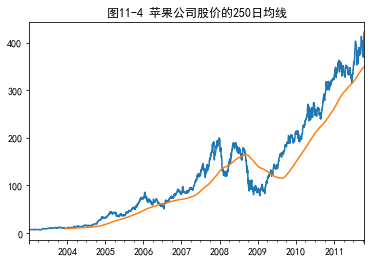

In [245]:
plt.rcParams['font.sans-serif'] = ['simhei']
close_px.AAPL.plot()
close_px.AAPL.rolling(250).mean().plot().set_title('图11-4 苹果公司股价的250日均线')

表达式rolling(250)与groupby很像，但不是对其进⾏分组、创建⼀个按照250天分组的滑动窗⼝对象。然后，我们就得到了苹果公司股价的250天的移动窗⼝。  

默认情况下，诸如rolling_mean这样的函数需要指定数量的⾮NA观测值。可以修改该⾏为以解决缺失数据的问题。其实，在时间序列开始处尚不⾜窗⼝期的那些数据就是个特例（⻅图11-5）：

In [246]:
appl_std250 = close_px.AAPL.rolling(250, min_periods=10).std()
appl_std250[5:12]

2003-01-09         NaN
2003-01-10         NaN
2003-01-13         NaN
2003-01-14         NaN
2003-01-15    0.077496
2003-01-16    0.074760
2003-01-17    0.112368
Freq: B, Name: AAPL, dtype: float64

Text(0.5, 1.0, '图11-5 苹果公司250日每日回报标准差')

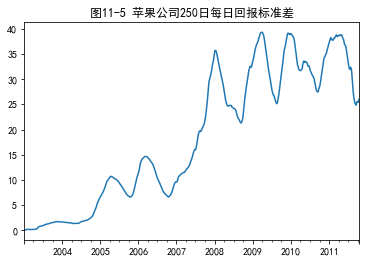

In [248]:
appl_std250.plot().set_title('图11-5 苹果公司250日每日回报标准差')

要计算扩展窗⼝平均（expanding window mean），可以使⽤expanding⽽不是rolling。“扩展”意味着，从时间序列的起始处开始窗⼝，增加窗⼝直到它超过所有的序列。apple_std250时间序列的扩展窗⼝平均如下所示：

In [249]:
expanding_mean = appl_std250.expanding().mean()

对DataFrame调⽤rolling_mean（以及与之类似的函数）会将转换应⽤到所有的列上（⻅图11-6）：

Text(0.5, 1.0, '图11-6 各股价60日均线（对数Y轴）')

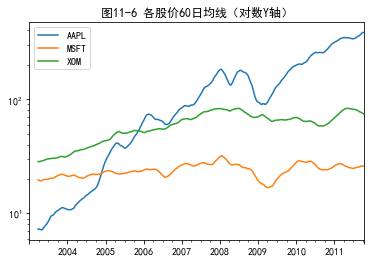

In [250]:
close_px.rolling(60).mean().plot(logy=True).set_title('图11-6 各股价60日均线（对数Y轴）')

rolling函数也可以接受⼀个指定固定⼤⼩时间补偿字符串，⽽不是⼀组时期。这样可以⽅便处理不规律的时间序列。这些字符串也可以传递给resample。例如，我们可以计算20天的滚动均值，如下所示：

In [251]:
close_px.rolling('20D').mean()

,AAPL,MSFT,XOM
2003-01-02,7.400000,21.110000,29.220000
2003-01-03,7.425000,21.125000,29.230000
2003-01-06,7.433333,21.256667,29.473333
2003-01-07,7.432500,21.425000,29.342500
2003-01-08,7.402000,21.402000,29.240000
...,...,...,...
2011-10-10,389.351429,25.602143,72.527857
2011-10-11,388.505000,25.674286,72.835000
2011-10-12,388.531429,25.810000,73.400714
2011-10-13,388.826429,25.961429,73.905000


### 指数加权函数
另⼀种使⽤固定⼤⼩窗⼝及相等权数观测值的办法是，定义⼀个衰减因⼦（decay factor）常量，以便使近期的观测值拥有更⼤的权数。衰减因⼦的定义⽅式有很多，⽐较流⾏的是使⽤时间间隔（span），它可以使结果兼容于窗⼝⼤⼩等于时间间隔的简单移动窗⼝（simple moving window）函数。  

由于指数加权统计会赋予近期的观测值更⼤的权数，因此相对于等权统计，它能“适应”更快的变化。  

除了rolling和expanding，pandas还有ewm运算符。下⾯这个例⼦对⽐了苹果公司股价的60⽇移动平均和`span=60`的指数加权移动平均（如图11-7所示）：

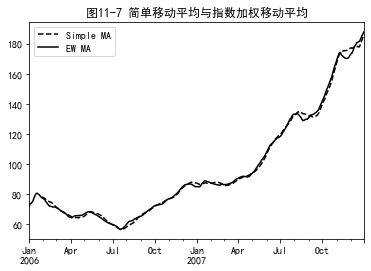

In [255]:
aapl_px = close_px.AAPL['2006':'2007']
ma60 = aapl_px.rolling(30, min_periods=20).mean()
ewma60 = aapl_px.ewm(span=30).mean()
ma60.plot(style='k--', label='Simple MA')
ewma60.plot(style='k-', label='EW MA').set_title('图11-7 简单移动平均与指数加权移动平均')
plt.legend()

### ⼆元移动窗⼝函数
有些统计运算（如相关系数和协⽅差）需要在两个时间序列上执⾏。例如，⾦融分析师常常对某只股票对某个参考指数（如标准普尔500指数）的相关系数感兴趣。要进⾏说明，我们先计算我们感兴趣的时间序列的百分数变化：

In [256]:
spx_px = close_px_all['SPX']
spx_rets = spx_px.pct_change()
returns = close_px.pct_change()

调⽤rolling之后，corr聚合函数开始计算与spx_rets滚动相关系数（结果⻅图11-8）：

Text(0.5, 1.0, '图11-8 AAPL 6个月的回报与标准普尔500指数的相关系数')

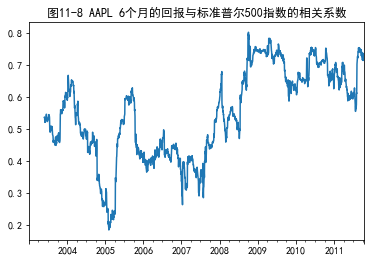

In [258]:
corr = returns.AAPL.rolling(125, min_periods=100).corr(spx_rets)
corr.plot().set_title('图11-8 AAPL 6个月的回报与标准普尔500指数的相关系数')

假设你想要⼀次性计算多只股票与标准普尔500指数的相关系数。虽然编写⼀个循环并新建⼀个DataFrame不是什么难事，但⽐较啰嗦。其实，只需传⼊⼀个TimeSeries和⼀个DataFrame，rolling_corr就会⾃动计算TimeSeries（本例中就是spx_rets）与DataFrame各列的相关系数。结果如图11-9所示：

Text(0.5, 1.0, '图11-9 3只股票6个月的回报与标准普尔500指数的相关系数')

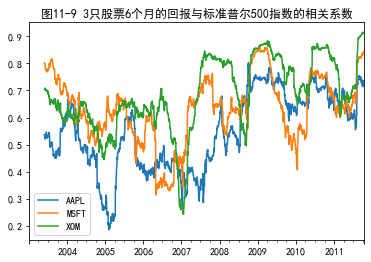

In [260]:
corr = returns.rolling(125, min_periods=100).corr(spx_rets)
corr.plot().set_title('图11-9 3只股票6个月的回报与标准普尔500指数的相关系数')

### ⽤户定义的移动窗⼝函数
rolling_apply函数使你能够在移动窗⼝上应⽤⾃⼰设计的数组函数。唯⼀要求的就是：该函数要能从数组的各个⽚段中产⽣单个值（即约简）。⽐如说，当我们⽤`rolling(...).quantile(q)`计算样本分位数时，可能对样本中特定值的百分等级感兴趣。  

`scipy.stats.percentileofscore`函数就能达到这个⽬的（结果⻅图11-10）：

Text(0.5, 1.0, '图11-10 AAPL 2%回报率的百分等级（一年窗口期）')

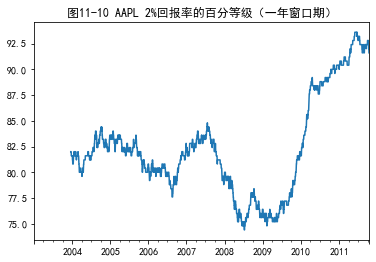

In [262]:
from scipy.stats import percentileofscore
score_at_2percent = lambda x: percentileofscore(x, 0.02)
result = returns.AAPL.rolling(250).apply(score_at_2percent)
result.plot().set_title('图11-10 AAPL 2%回报率的百分等级（一年窗口期）')